With this notebook we try to evaluate the exact overlap between a base table and
the candidate tables. This is to observe whether MinHash is a good proxy of this 
metric over "small" data lakes. 

Note that this approach does not scale (that's what MinHash and Lazo are for, 
after all!). 

However, our use case should be small enough for this to not be a problem. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [41]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import sklearn.metrics as metrics
from joblib import Parallel, delayed, dump, load
from tqdm import tqdm
import seaborn as sns

import src.methods.profiling as jp
from src.data_structures.join_discovery_methods import MinHashIndex

In [4]:
def evaluate_one_table(fpath, df_base, query_column):
    overlap_dict = {}
    with open(fpath) as fp:
        mdata = json.load(fp)
        cnd_path = mdata["full_path"]
        cnd_hash = mdata["hash"]
        df_cnd = pl.read_parquet(cnd_path)
        for col in df_cnd.columns:
            pair = (cnd_hash, col)

            cont = jp.measure_containment(
                df_base, df_cnd, left_on=[query_column], right_on=[col]
            )
            overlap_dict[pair] = cont
    return overlap_dict

In [5]:
def exact_matching(mdata_path, df_base, query_column):
    # Building the pairwise distance with joblib
    r = Parallel(n_jobs=8, verbose=0)(
        delayed(evaluate_one_table)(fpath, df_base, query_column)
        for idx, fpath in tqdm(
            enumerate(mdata_path.glob("*.json")),
            position=0,
            leave=False,
            total=sum([1 for _ in mdata_path.glob("*.json")]),
        )
    )

    overlap_dict = {key: val for result in r for key, val in result.items()}
    df_overlap = pl.from_dict(
        {"key": list(overlap_dict.keys()), "overlap": list(overlap_dict.values())}
    )
    df_overlap = df_overlap.with_columns(
        pl.col("key").list.to_struct().struct.rename_fields(["hash", "col"])
    ).unnest("key")
    return df_overlap

In [6]:
def minhash_matching(index, query_column_values):
    # Querying index for any candidates
    query_result = index.query_index(query_column_values)
    return query_result

In [7]:
def evaluate_results(df_overlap, df_pred, threshold=0.2):
    # Adding a column that marks as "true" all columns with overlap higher than `threshold`
    df_true = df_overlap.with_columns(
        pl.when(
            pl.col("overlap") > threshold,
        )
        .then(1)
        .otherwise(0)
        .alias("mask_true")
    )
    # Join the two tables to measure recall
    combined = (
        df_true.join(df_pred, on=["hash", "col"], how="left")
        .with_columns(
            pl.when(
                pl.col("score").is_not_null(),
            )
            .then(1)
            .otherwise(0)
            .alias("mask_pred")
        )
        .sort("overlap", descending=True)
    )

    # Prepare a simplified df
    c_df = combined.select(pl.col("mask_true"), pl.col("mask_pred")).to_pandas()
    return combined, c_df

In [8]:
def print_results(c_df, data_lake_case, table_name):
    print(f"{data_lake_case} : {table_name}")
    # Preparing confusion matrix
    conf_m = metrics.confusion_matrix(c_df["class"], c_df["class_pred"])
    tn, fp, fn, tp = conf_m.ravel()
    print(f"{'True Negative:':<40}{tn:>6}")
    print(f"{'False Positive:':<40}{fp:>6}")
    print(f"{'False Negative:':<40}{fn:>6}")
    print(f"{'True Positive:':<40}{tp:>6}")
    recall = metrics.recall_score(c_df["class"], c_df["class_pred"])
    print(f"{'Recall:':<40}{recall:>6.3f}")
    precision = metrics.precision_score(c_df["class"], c_df["class_pred"])
    print(f"{'Precision:':<40}{precision:>6.3f}")
    # Measure the F1 score
    f1 = metrics.f1_score(c_df["class"], c_df["class_pred"])
    print(f"{'F1 score:':<40}{f1:>6.3f}")
    auc = metrics.roc_auc_score(c_df["class"], c_df["class_pred"])
    print(f"{'AUC score:':<40}{auc:>6.3f}")

In [9]:
cfg = pl.Config()
cfg.set_fmt_str_lengths(30)

polars.config.Config

In [4]:
mdata_root_dir = Path("data/metadata/")
data_lake_case = "wordnet_big"
mdata_path = Path(mdata_root_dir, data_lake_case)

table_name = "company-employees-yadl"
base_table_path = f"data/source_tables/{table_name}.parquet"
df_base = pl.read_parquet(base_table_path)
query_column = "col_to_embed"

In [5]:
index = MinHashIndex()
with open(
    f"data/metadata/_indices/{data_lake_case}/minhash_index_60.pickle", "rb"
) as fp:
    input_dict = load(fp)
    index.load_index(index_dict=input_dict)

### Measuring the F1 Score
In this scenario:
- `TP`: Matches with `overlap` >= `threshold` found by Minhash
- `FP`: Matches with `overlap` < `threshold`, yet marked as matches by Minhash
- `FN`: Matches with `overlap` >= `threshold` missed by Minhash
- `TN`: Matches with `overlap` < `threshold` not returned by Minhash

# Working with joblib

In [12]:
query_column = "col_to_embed"
result_list = []
total_cases = sum(
    [1 for _ in Path("data/metadata/_indices/wordnet_big/").glob("**/minhash_index_*")]
)
for path in tqdm(
    Path("data/metadata/_indices/wordnet_big/").glob("**/minhash_index_*"),
    total=total_cases,
):
    index = MinHashIndex()
    with open(path, "rb") as fp:
        input_dict = load(fp)
        index.load_index(index_dict=input_dict)

    for table_name in [
        "company-employees-yadl",
        "movies-yadl",
        "us-accidents-yadl",
        "us-presidential-results-yadl",
    ]:
        base_table_path = f"data/source_tables/{table_name}.parquet"
        df_base = pl.read_parquet(base_table_path)
        query_column_values = df_base[query_column].to_list()

        query_result = minhash_matching(index, query_column_values)
        # Preparing the same dataframe as before for prediction
        ll = [[row[i] for row in query_result] for i in range(3)]
        df_pred = pl.from_dict(
            dict(zip(["hash", "col", "score"], ll)),
            schema=[("hash", str), ("col", str), ("score", float)],
        )
        df_pred = df_pred.with_columns(
            pl.lit(path.stem).alias("index_case"),
            pl.lit(table_name).alias("table_name"),
        )
        result_list.append(df_pred)

100%|██████████| 5/5 [01:43<00:00, 20.79s/it]


In [13]:
df_pred = pl.concat(result_list)

In [14]:
overlap_dict = {}
# for table_name in ["us-accidents-yadl"]:
for table_name in [
    "company-employees-yadl",
    "movies-yadl",
    "us-accidents-yadl",
    "us-presidential-results-yadl",
]:
    data_lake_case = "wordnet_big"
    mdata_path = Path(mdata_root_dir, data_lake_case)
    mdata_root_dir = Path("data/metadata/")
    data_lake_case = "wordnet_big"
    mdata_path = Path(mdata_root_dir, data_lake_case)

    base_table_path = f"data/source_tables/{table_name}.parquet"
    df_base = pl.read_parquet(base_table_path)
    query_column = "col_to_embed"
    df_overlap = exact_matching(mdata_path, df_base, query_column)

    # query_result = minhash_matching(index, query_column)
    # # Preparing the same dataframe as before for prediction
    # ll = [[row[i] for row in query_result] for i in range(3)]
    # df_pred = pl.from_dict(dict(zip(["hash", "col", "score"], ll)))

    # combined, c_df = evaluate_results(df_overlap, df_pred, threshold=0.2)
    # print_results(c_df, data_lake_case, table_name)
    # res_dict[table_name] = combined
    overlap_dict[table_name] = df_overlap

res_list = []
for tab_name, tab in overlap_dict.items():
    tab = tab.with_columns(pl.lit(tab_name).alias("table_name"))
    res_list.append(tab)
df_exact = pl.concat(res_list)    

 45%|████▌     | 1856/4080 [00:28<00:30, 73.43it/s] /home/soda/rcappuzz/mambaforge/envs/bench-repro/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [44]:
stats = []
for idx, group in df_pred.group_by(["table_name", "index_case"]):
    print(idx)
    idx_case = float(idx[1].split("_")[-1])
    df_group = (
        df_exact
        .filter(pl.col("table_name") == idx[0])
        .with_columns(
            (pl.lit(idx_case).alias("thr"))
        )
        .join(group, on=["table_name", "hash", "col"], how="left")
        .with_columns(
            pl
            .when(pl.col("overlap") >= pl.col("thr") / 100)
            .then(1)
            .when(pl.col("score").is_null())
            .then(0)
            .otherwise(0)
            .alias("class")
        )
        .with_columns(
            pl.when(
                pl.col("score").is_null(),
            )
            .then(0)
            .otherwise(1)
            .alias("class_pred")
        )
    )

    c_df = df_group.select(pl.col("class"), pl.col("class_pred")).to_pandas()
    
    conf_m = metrics.confusion_matrix(c_df["class"], c_df["class_pred"])
    tn, fp, fn, tp = conf_m.ravel()

    recall = metrics.recall_score(c_df["class"], c_df["class_pred"])
    precision = metrics.precision_score(c_df["class"], c_df["class_pred"])
    f1 = metrics.f1_score(c_df["class"], c_df["class_pred"])
    # Prepare a simplified df
    rd = {
        "table_name": idx[0],
        "case": idx[1],
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
    }
    
    stats.append(rd)
df_stats = pl.from_dicts(stats)

('movies-yadl', 'minhash_index_10')
('movies-yadl', 'minhash_index_60')
('movies-yadl', 'minhash_index_40')
('company-employees-yadl', 'minhash_index_10')
('company-employees-yadl', 'minhash_index_60')
('us-accidents-yadl', 'minhash_index_20')
('company-employees-yadl', 'minhash_index_40')
('us-presidential-results-yadl', 'minhash_index_20')
('us-accidents-yadl', 'minhash_index_80')
('movies-yadl', 'minhash_index_20')
('us-accidents-yadl', 'minhash_index_10')
('us-accidents-yadl', 'minhash_index_60')
('us-presidential-results-yadl', 'minhash_index_10')
('us-presidential-results-yadl', 'minhash_index_60')
('us-presidential-results-yadl', 'minhash_index_40')
('company-employees-yadl', 'minhash_index_20')
('us-accidents-yadl', 'minhash_index_40')


/home/soda/rcappuzz/mambaforge/envs/bench-repro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
df_stats.sort(["table_name", "case"]).with_columns((pl.col("tp")  + pl.col("fp") ).alias("n_candidates"))

table_name,case,precision,recall,f1,tp,tn,fp,fn,thr,n_candidates
str,str,f64,f64,f64,i64,i64,i64,i64,f64,i64
"""company-employees-yadl""","""minhash_index_10""",0.119342,0.935484,0.211679,29,19131,214,2,10.0,243
"""company-employees-yadl""","""minhash_index_20""",0.076923,0.846154,0.141026,11,19231,132,2,20.0,143
"""company-employees-yadl""","""minhash_index_40""",0.067568,1.0,0.126582,5,19302,69,0,40.0,74
"""company-employees-yadl""","""minhash_index_60""",0.130435,1.0,0.230769,3,19353,20,0,60.0,23
"""movies-yadl""","""minhash_index_10""",0.434783,0.909091,0.588235,10,19352,13,1,10.0,23
"""movies-yadl""","""minhash_index_20""",0.529412,0.9,0.666667,9,19358,8,1,20.0,17
"""movies-yadl""","""minhash_index_40""",0.352941,1.0,0.521739,6,19359,11,0,40.0,17
"""movies-yadl""","""minhash_index_60""",0.333333,1.0,0.5,4,19364,8,0,60.0,12
"""us-accidents-yadl""","""minhash_index_10""",0.397906,1.0,0.569288,76,19185,115,0,10.0,191


In [46]:
df_stats = df_stats.with_columns(pl.col("case").str.split("_").list[-1].cast(float).alias("thr"))

In [51]:
_df = df_stats.melt(id_vars=["table_name", "thr"], value_vars=[ "precision", "recall", 'f1'])

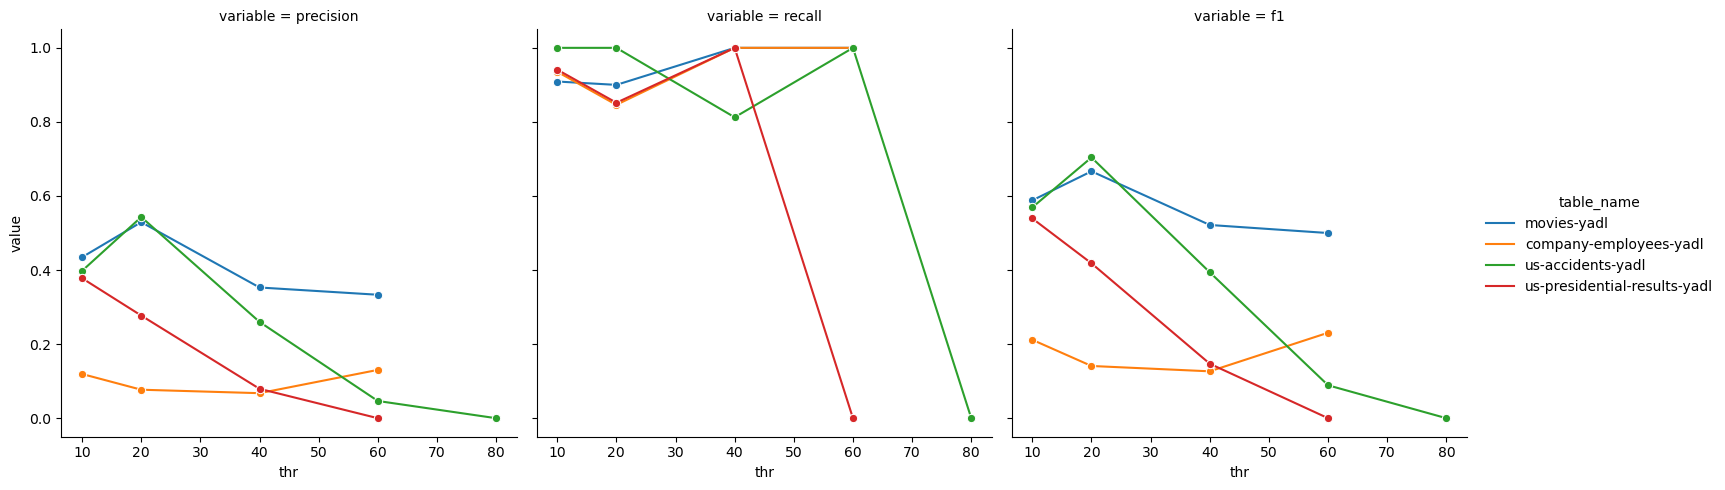

In [58]:
sns.relplot(data=_df.to_pandas(), col="variable", x="thr", y="value", kind="line", hue="table_name", marker='o')